In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

import string

from nltk.stem.porter import PorterStemmer

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
reviews=pd.read_csv('/content/drive/MyDrive/Capstone/sample30.csv')

In [6]:
reviews.shape

(30000, 15)

In [7]:
reviews.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [8]:
#number of users
print('Number of users = {}'.format (len (pd.unique(reviews['reviews_username']))))
print('Number of items = {}'.format(len(pd.unique(reviews['id']))))


Number of users = 24915
Number of items = 271


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


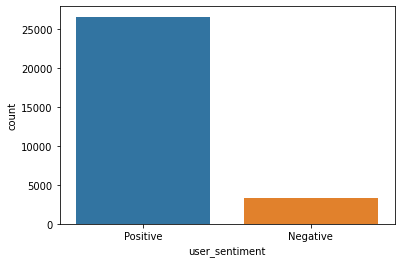

In [9]:
sns.countplot(reviews['user_sentiment'])

Data is imbalanced so we have to handle that while building a model

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


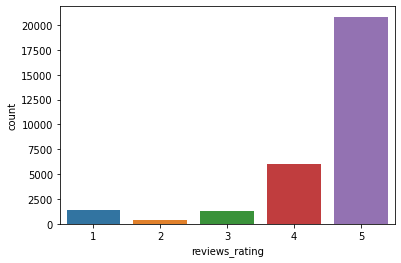

In [10]:
sns.countplot(reviews.reviews_rating)

In [11]:
reviews.categories.value_counts()

Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Cleaning & Janitorial Supplies,Cleaners & Disinfectants,Cleaning Wipes & Pads,Cleaning Solutions,Housewares,Target Restock,Food & Grocery,Paper Goods,Wipes,All Purpose Cleaners    8545
Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys                                                                                                                                                                                                                                                                                                                                                                                                   3325
Household Chemicals,Household Cleaners,Bath & 

## Bulding The sentiment Analyzer Model

In [12]:
reviews.reviews_title.isnull().sum()

190

In [13]:
reviews.reviews_text.isnull().sum()

0

In [14]:
reviews.user_sentiment.isnull().sum()

1

Reviews Title is missing at 190 reviews but text is present for every item and for one item sentiment is missing.

In [15]:
reviews[reviews['user_sentiment'].isnull()]

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2014-11-07T00:00:00.000Z,NaN,True,5,my kids absolutely loved this film so much tha...,a super hit with my children. they loved it!!??,NaN,mamad,7.87E+11,NaN


In [16]:
# for the above item rating was 5 and that seems positive so lets impute it with positive sentiment
reviews.loc[reviews['user_sentiment'].isnull(),'user_sentiment']='Positive'
reviews.loc[reviews['reviews_title'].isnull(),'reviews_title']=''

In [17]:
# concatenating reviews_title and reviews_text field for sentiment analysis
reviews['review']= reviews.reviews_title+ ' ' + reviews.reviews_text

## Text Preprocessing

In [18]:
## Lowercasing of text
reviews['review']=reviews['review'].str.lower()


In [19]:
## removing stopwords
stopwords=set(stopwords.words('english'))
reviews['review']=reviews['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

In [20]:
reviews['review'].head()

0    awesome love album. good. hip hop side current...
1    good good flavor. review collected part promot...
2                                    good good flavor.
3    disappointed read reviews looking buying one c...
4    irritation husband bought gel us. gel caused i...
Name: review, dtype: object

In [21]:
# removing special characters and punctuations
string.punctuation
def func(x):
  for i in x:
    if i in list(string.punctuation):
      x=x.replace(i,'')
  return x


reviews['review']=reviews['review'].apply(func)

In [22]:
reviews['review']

0        awesome love album good hip hop side current p...
1         good good flavor review collected part promotion
2                                         good good flavor
3        disappointed read reviews looking buying one c...
4        irritation husband bought gel us gel caused ir...
                               ...                        
29995    softness got conditioner influenster try im lo...
29996    love love  received review purposes influenste...
29997    hair smooth use first love smell product wash ...
29998    perfect oily hair received influenster never g...
29999    conditioned healthy received product complimen...
Name: review, Length: 30000, dtype: object

In [23]:
#Tokenization
reviews['review']=reviews['review'].apply(lambda x:word_tokenize(x))

In [24]:
#Stemming
stemmer=PorterStemmer()
reviews['review']=reviews['review'].apply(lambda x:[stemmer.stem(word) for word in x])


In [25]:
reviews['review']

0        [awesom, love, album, good, hip, hop, side, cu...
1        [good, good, flavor, review, collect, part, pr...
2                                     [good, good, flavor]
3        [disappoint, read, review, look, buy, one, cou...
4        [irrit, husband, bought, gel, us, gel, caus, i...
                               ...                        
29995    [soft, got, condition, influenst, tri, im, lov...
29996    [love, love, receiv, review, purpos, influenst...
29997    [hair, smooth, use, first, love, smell, produc...
29998    [perfect, oili, hair, receiv, influenst, never...
29999    [condit, healthi, receiv, product, complimenta...
Name: review, Length: 30000, dtype: object

In [26]:
#extracting features using tfidfvectorizer
vect= TfidfVectorizer(max_features=1000,ngram_range=(1,2))

In [27]:
reviews['review']=reviews['review'].apply(lambda x:' '.join(word for word in x))

In [28]:
reviews['review']

0        awesom love album good hip hop side current po...
1              good good flavor review collect part promot
2                                         good good flavor
3        disappoint read review look buy one coupl lubr...
4        irrit husband bought gel us gel caus irrit fel...
                               ...                        
29995    soft got condition influenst tri im love far o...
29996    love love receiv review purpos influenst leav ...
29997    hair smooth use first love smell product wash ...
29998    perfect oili hair receiv influenst never go ba...
29999    condit healthi receiv product complimentari in...
Name: review, Length: 30000, dtype: object

In [29]:
x_features=vect.fit_transform(reviews['review'])

In [30]:
x_features

<30000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 515926 stored elements in Compressed Sparse Row format>

In [31]:
vect.get_feature_names()

['10',
 '15',
 '20',
 '3d',
 'abl',
 'absolut',
 'absolut love',
 'act',
 'action',
 'action movi',
 'action pack',
 'actor',
 'actual',
 'ad',
 'add',
 'addit',
 'adult',
 'again',
 'age',
 'ago',
 'all',
 'allow',
 'almost',
 'along',
 'alot',
 'alreadi',
 'also',
 'also use',
 'although',
 'alway',
 'alway use',
 'amaz',
 'amaz product',
 'amount',
 'and',
 'anoth',
 'anymor',
 'anyon',
 'anyth',
 'anyth els',
 'anywher',
 'appear',
 'appli',
 'applic',
 'area',
 'around',
 'around hous',
 'ask',
 'assembl',
 'avail',
 'aw',
 'away',
 'awesom',
 'awesom love',
 'awesom movi',
 'awesom product',
 'babi',
 'back',
 'back cocoa',
 'back old',
 'bad',
 'bag',
 'balm',
 'base',
 'bath',
 'bathroom',
 'bathroom kitchen',
 'beat',
 'beauti',
 'becom',
 'bee',
 'begin',
 'behind',
 'believ',
 'best',
 'best buy',
 'best godzilla',
 'best product',
 'better',
 'big',
 'binder',
 'bit',
 'black',
 'bleach',
 'blend',
 'blu',
 'blu ray',
 'blue',
 'bluray',
 'bodi',
 'bottl',
 'bought',
 'box'

In [32]:
#Train test Split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_features,reviews['user_sentiment'],test_size=0.3,random_state=2)

In [33]:
pd.DataFrame(x_train.toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.263565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.267849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.290666,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.173674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
20996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.207853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
20997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.198772,0.311139,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.170385,0.245081,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.18851,0.0,0.0,0.0,0.0,0.0
20998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


In [34]:
y_train

12614    Positive
5357     Positive
4020     Positive
24851    Positive
23961    Positive
           ...   
18898    Positive
11798    Positive
6637     Positive
2575     Positive
23720    Positive
Name: user_sentiment, Length: 21000, dtype: object

In [35]:
lr1=LogisticRegression()
lr1.fit(x_train,y_train)
y_pred=lr1.predict(x_test)
metrics.accuracy_score(y_test,y_pred)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    Negative       0.74      0.24      0.37       990
    Positive       0.91      0.99      0.95      8010

    accuracy                           0.91      9000
   macro avg       0.83      0.62      0.66      9000
weighted avg       0.89      0.91      0.89      9000



So we got 90.7% accuracy but there is imbalance in classes so to handle that we can use over sampling

In [36]:
from imblearn.over_sampling import SMOTE
sm=SMOTE(random_state=2)
data_train,target_train=sm.fit_sample(x_train,y_train.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [37]:
lr2=LogisticRegression()
lr2.fit(data_train,target_train)
y_pred=lr2.predict(x_test)
metrics.accuracy_score(y_test,y_pred)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    Negative       0.47      0.71      0.57       990
    Positive       0.96      0.90      0.93      8010

    accuracy                           0.88      9000
   macro avg       0.72      0.81      0.75      9000
weighted avg       0.91      0.88      0.89      9000



In [38]:
from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB()
mnb.fit(data_train,target_train)
y_pred=mnb.predict(x_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    Negative       0.30      0.66      0.42       990
    Positive       0.95      0.81      0.88      8010

    accuracy                           0.80      9000
   macro avg       0.63      0.74      0.65      9000
weighted avg       0.88      0.80      0.83      9000



In [39]:

rfc=RandomForestClassifier(max_depth=5)
rfc.fit(data_train,target_train)
y_pred=rfc.predict(x_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    Negative       0.23      0.65      0.34       990
    Positive       0.94      0.72      0.82      8010

    accuracy                           0.72      9000
   macro avg       0.59      0.69      0.58      9000
weighted avg       0.87      0.72      0.77      9000



In [40]:
import xgboost as xgb
xg=xgb.XGBClassifier(random_state=42)
xg.fit(data_train,target_train)
y_pred=xg.predict(x_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    Negative       0.33      0.65      0.44       990
    Positive       0.95      0.84      0.89      8010

    accuracy                           0.82      9000
   macro avg       0.64      0.74      0.66      9000
weighted avg       0.88      0.82      0.84      9000



According to the above exercise we found that best results obatained using logistic regression with oversampling. Thus lr2 will be used as final model.

In [41]:
# Function which takes item id as input and return % of postive reviews
def reviews_sentment(item_id):
  item_reviews=reviews.loc[reviews['id']==item_id,'review']
  item_features=vect.transform(item_reviews)
  sentiment=lr2.predict(item_features)
  sentiment=[1 if x=='Positive' else 0 for x in sentiment]
  pos_reviews=sum(sentiment)
  pos_reviews_percent=100*pos_reviews/len(sentiment)
  return pos_reviews_percent

In [42]:
reviews_sentment('AV16khLE-jtxr-f38VFn')

40.74074074074074

## Building Recommendation Engine

### User based collaborative filtering

In [43]:
# fetching ratings in a separate data frame
ratings=reviews[['id','reviews_username','reviews_rating']]

Exploring ratings dataframe

In [44]:
ratings.head()

,id,reviews_username,reviews_rating
0,AV13O1A8GV-KLJ3akUyj,joshua,5
1,AV14LG0R-jtxr-f38QfS,dorothy w,5
2,AV14LG0R-jtxr-f38QfS,dorothy w,5
3,AV16khLE-jtxr-f38VFn,rebecca,1
4,AV16khLE-jtxr-f38VFn,walker557,1


In [45]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                30000 non-null  object
 1   reviews_username  29937 non-null  object
 2   reviews_rating    30000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 703.2+ KB


In [46]:
ratings.isnull().sum(axis=0)

id                   0
reviews_username    63
reviews_rating       0
dtype: int64

In [47]:
# user name is missing so lets get rid of such ratings
ratings=ratings.dropna()
ratings.shape

(29937, 3)

In [48]:
ratings.describe()

,reviews_rating
count,29937.000000
mean,4.484117
std,0.986763
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [49]:
ratings[['id','reviews_username']].describe()

,id,reviews_username
count,29937,29937
unique,271,24914
top,AVpf3VOfilAPnD_xjpun,mike
freq,8525,41


In [50]:
#per item count of ratings
ratings['id'].value_counts()

AVpf3VOfilAPnD_xjpun    8525
AVpfPaoqLJeJML435Xk9    3325
AVpfJP1C1cnluZ0-e3Xy    2039
AVpfW8y_LJeJML437ySW    1186
AVpfRTh1ilAPnD_xYic2    1143
                        ... 
AVpfbjraLJeJML439F91       1
AVpfP-rELJeJML435jEN       1
AVpfsQoeilAPnD_xgfx5       1
AVpfbpzd1cnluZ0-kqJV       1
AVpfi79RLJeJML43_Jo0       1
Name: id, Length: 271, dtype: int64

Spltting data into train and test set

In [51]:
train,test=train_test_split(ratings,test_size=0.3,random_state=32)

In [52]:
print(train.shape)
print(test.shape)

(20955, 3)
(8982, 3)


In [53]:
train[train['reviews_username']=='joshua']

,id,reviews_username,reviews_rating
22742,AVpfoSS51cnluZ0-oVH9,joshua,5
1559,AVpe31o71cnluZ0-YrSD,joshua,3
17859,AVpfBwE4ilAPnD_xTWO1,joshua,5
0,AV13O1A8GV-KLJ3akUyj,joshua,5


In [54]:
#creating a pivot using train set
df_pivot = train.pivot_table(
    index='reviews_username',columns='id',values='reviews_rating'
).fillna(0)

df_pivot.head(3)

id,AV13O1A8GV-KLJ3akUyj,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,...,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
#creating a dummy_train to mask the items not rated by user
dummy_train=train.copy()
dummy_train.head()

,id,reviews_username,reviews_rating
20354,AVpfJP1C1cnluZ0-e3Xy,senta,5
14017,AVpf3VOfilAPnD_xjpun,isha,5
18332,AVpfFs_1ilAPnD_xUtRm,tomanneke,4
20545,AVpfJP1C1cnluZ0-e3Xy,shann,5
15593,AVpf5Z1zLJeJML43FpB-,melissa c.,3


In [56]:
dummy_train['reviews_rating']=dummy_train['reviews_rating'].apply(lambda x:0 if x>=1 else 1)
#making unrated items as 1 and rated items as zero

In [57]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot_table(
    index='reviews_username',columns='id',values='reviews_rating'
).fillna(1)

In [58]:
# User similarity matrix using adjusted cosine similarity
df_pivot.index.nunique()

18231

In [59]:
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]]


In [60]:
user_correlation.shape

(18231, 18231)

In [61]:
#making all negative similarity users to zero
user_correlation[user_correlation<0]=0
#checking the sum of similarity matrix
user_correlation.sum()

37978312.8376919

In [62]:
# predicted ratings
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings


array([[ 0.        ,  0.        ,  1.61561407, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 16.27243892, ...,  0.        ,
         2.15165741,  0.        ],
       [ 0.        ,  2.09656967, 13.95439107, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        , 11.28758383, ...,  0.        ,
         0.        ,  2.88675135],
       [ 0.        ,  0.        , 16.27243892, ...,  0.        ,
         2.15165741,  0.        ],
       [ 0.        ,  0.        , 11.28758383, ...,  0.        ,
         0.        ,  2.88675135]])

In [63]:
#finaly masking out already rated items by multiplying it with the dummy train
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,...,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.00000,1.615614,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,6.928969,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.323123,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
00sab00,0.0,0.00000,16.272439,0.0,0.0,0.0,0.610847,0.000000,2.041241,0.0,0.0,0.000000,0.0,0.0,0.000000,3.454279,1.2,0.000000,0.0,0.0,2.096570,0.000000,2.443389,2.285714,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,16.249998,0.0,0.0,76.085038,0.0,0.0,1.995217,3.123475,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.12132,0.000000,0.0,0.0,0.323123,4.005792,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,4.985082,3.353123,0.000000,1.552301,0.0,0.0,0.000000,0.00000,0.46225,0.0,0.0,0.0,0.0,0.0,0.000000,1.734587,0.0,2.151657,0.000000
02deuce,0.0,2.09657,13.954391,0.0,0.0,0.0,0.000000,2.555506,1.766904,0.0,0.0,1.866915,0.0,0.0,1.849001,3.581176,0.0,2.073221,0.0,0.0,2.620712,0.000000,0.000000,9.279698,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,25.681982,0.0,0.0,114.259189,0.0,0.0,1.995217,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,2.886751,0.0,0.0,0.000000,8.549536,0.0,0.0,0.0,0.488678,0.0,0.0,0.0,5.917285,9.186261,3.123475,1.360828,0.0,0.0,1.927588,2.46183,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,3.106056,0.0,0.000000,0.000000
06stidriver,0.0,0.00000,11.287584,0.0,0.0,0.0,3.123475,0.000000,4.075713,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,9.545760,0.0,0.0,0.0,0.0,0.0,3.535534,0.0,0.000000,5.049065,0.0,0.0,28.750118,0.0,0.0,0.000000,0.000000,...,3.535534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,5.122819,9.427904,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,4.587786,0.000000,3.848421,0.0,0.0,0.000000,0.00000,0.46225,0.0,0.0,0.0,0.0,0.0,2.886751,0.000000,0.0,0.000000,2.886751
09mommy11,0.0,0.00000,5.952932,0.0,0.0,0.0,3.535534,0.617213,5.164717,0.0,0.0,0.000000,0.0,0.0,0.000000,1.522764,0.0,0.000000,0.0,0.0,0.000000,2.443389,0.000000,5.773503,0

In [64]:
#printing top 20 recommendation
user_final_rating.loc['joshua'].sort_values(ascending=False)[0:20]

id
AVpfPaoqLJeJML435Xk9    11.634545
AVpe59io1cnluZ0-ZgDU     8.038646
AVpf0eb2LJeJML43EVSt     5.276366
AVpfRTh1ilAPnD_xYic2     5.223455
AVpe41TqilAPnD_xQH3d     4.405077
AVpf2tw1ilAPnD_xjflC     3.061806
AVpfM_ytilAPnD_xXIJb     2.828781
AVpfOmKwLJeJML435GM7     2.507429
AVpe8gsILJeJML43y6Ed     2.314231
AVpfR5m0LJeJML436K3W     2.292689
AVpe7sl91cnluZ0-aI1Y     2.117124
AVpfPnrU1cnluZ0-g9rL     1.929346
AVpfQtEm1cnluZ0-hUpe     1.775597
AV1l8zRZvKc47QAVhnAv     1.703995
AVpfrFDZLJeJML43Bmv0     1.678798
AVpf3VOfilAPnD_xjpun     1.652694
AVpfMpZ51cnluZ0-f_L9     1.637200
AVpf5olc1cnluZ0-tPrO     1.602709
AVpf385g1cnluZ0-s0_t     1.593728
AV1Ys0kTvKc47QAVgx1C     1.157275
Name: joshua, dtype: float64

Evaluation of the user-user recommender system

In [65]:
train.head()

,id,reviews_username,reviews_rating
20354,AVpfJP1C1cnluZ0-e3Xy,senta,5
14017,AVpf3VOfilAPnD_xjpun,isha,5
18332,AVpfFs_1ilAPnD_xUtRm,tomanneke,4
20545,AVpfJP1C1cnluZ0-e3Xy,shann,5
15593,AVpf5Z1zLJeJML43FpB-,melissa c.,3


In [66]:
test.head()

,id,reviews_username,reviews_rating
10975,AVpf3VOfilAPnD_xjpun,burrelly,5
29501,AVpfW8y_LJeJML437ySW,helen8947,4
4594,AVpf0eb2LJeJML43EVSt,phil,4
24114,AVpfPaoqLJeJML435Xk9,hotrod,4
23774,AVpfPaoqLJeJML435Xk9,diableblanc,4


In [67]:
common=test[test.reviews_username.isin(train.reviews_username)]
common.head()

,id,reviews_username,reviews_rating
29501,AVpfW8y_LJeJML437ySW,helen8947,4
4594,AVpf0eb2LJeJML43EVSt,phil,4
3660,AVpe71Vk1cnluZ0-aL_Z,rhonda,5
28356,AVpfRTh1ilAPnD_xYic2,electrotnicjunky,5
25164,AVpfPaoqLJeJML435Xk9,nicky,5


In [68]:
test.reviews_username.count()

8982

In [69]:
common.reviews_username.nunique()

1687

In [70]:
common_user_matrix=common.pivot_table(index='reviews_username',columns='id',values='reviews_rating')
common_user_matrix

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf0O60ilAPnD_xizE6,AVpf0eb2LJeJML43EVSt,...,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRoqcLJeJML436FqG,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfiUrfLJeJML43-9nY,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234asdf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23jen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yvonne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [71]:
user_correlation_df=pd.DataFrame(user_correlation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,18191,18192,18193,18194,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204,18205,18206,18207,18208,18209,18210,18211,18212,18213,18214,18215,18216,18217,18218,18219,18220,18221,18222,18223,18224,18225,18226,18227,18228,18229,18230
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.514496,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.6,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.529813,1.0,1.0,0.0,0.0,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.624695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
user_correlation_df.shape

(18231, 18231)

In [73]:
df_pivot.shape

(18231, 261)

In [74]:
user_correlation_df['user_name']=df_pivot.index
user_correlation_df.set_index('user_name',inplace=True)
user_correlation_df.columns=df_pivot.index.tolist()
user_correlation_df.shape

(18231, 18231)

In [75]:
user_correlation_df.head()

,00dog3,00sab00,02deuce,06stidriver,09mommy11,1085,10ten,1143mom,11677j,1234,1234561,1234567,1234asdf,123cat123,123charlie,123rs,123soccermom,127726,12gage,132457,13ld,13ram,143st,148maine,15425shopper,1616,1753,17roses,1863philly,1943,1950rmm,1968bear,1970,1992firebirdgirl,19bubba67,1awesome1,1boomer,1buzymom,1cadet,1clean1,...,zimmeyb,zina911,zink,zinnian,zipflip,zipper,zipperdoo,zippity,zippy,zitro,zkondrk,zmikez,zmom,znxfyt,zoeellasca,zoey,zoeyny,zokhid,zombie,zombiedad80,zombiegirl22,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zoomin76,zoso60,zout22389,zowie,zozo0o,zsarah,zsazsa,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
user_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
02deuce,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.514496,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.6,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.529813,1.0,1.0,0.0,0.0,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.624695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
09mommy11,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
list_cols=common.reviews_username
len(list_cols)

1985

In [77]:
list_cols=common.reviews_username
user_correlation_df=user_correlation_df[user_correlation_df.index.isin(list_cols)] #taking common users on the rows
user_correlation_df.shape

(1687, 18231)

In [78]:
user_correlation_df1=user_correlation_df.T
user_correlation_df1.shape

(18231, 1687)

In [79]:
user_correlation_df1=user_correlation_df1[user_correlation_df1.index.isin(list_cols)] #taking common users on the rows
user_correlation_df1.shape

(1687, 1687)

So we are finally have user similarity matrix for all common users between train and test set in user_correlation_df1. We can find dot product of this and common_user_matrix to find predicted rating

In [80]:
common_user_predicted_rating=np.dot(user_correlation_df1,common_user_matrix.fillna(0))

In [81]:
common_user_predicted_rating

array([[ 0.        ,  0.        ,  0.        , ...,  1.73458728,
         0.        ,  0.57735027],
       [ 0.        ,  7.73457702,  0.        , ...,  0.91900679,
         0.        ,  0.        ],
       [ 0.        ,  3.4326218 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 3.53553391, 22.30735586,  0.        , ...,  1.63546801,
         0.        ,  0.        ],
       [ 2.12132034, 13.38441351,  0.        , ...,  0.98128081,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  1.73458728,
         0.        ,  0.57735027]])

So we have found the predicted test rating but we don't want to check all ratings thus we have to create a dummy_test matrix for removing unrated items

In [82]:
# creating dummy test
dummy_test=common.copy()
dummy_test['reviews_rating']=dummy_test['reviews_rating'].apply( lambda x: 1 if x>=1 else 0)
dummy_test=dummy_test.pivot_table(index='reviews_username',columns='id',values='reviews_rating')
dummy_test=dummy_test.fillna(0)
dummy_test.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf0O60ilAPnD_xizE6,AVpf0eb2LJeJML43EVSt,...,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRoqcLJeJML436FqG,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfiUrfLJeJML43-9nY,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234asdf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23jen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
dummy_test.shape

(1687, 130)

In [84]:
common_user_predicted_rating=np.multiply(common_user_predicted_rating,dummy_test)
common_user_predicted_rating.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf0O60ilAPnD_xizE6,AVpf0eb2LJeJML43EVSt,...,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRoqcLJeJML436FqG,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfiUrfLJeJML43-9nY,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.10328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234asdf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23jen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)


MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [86]:
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan

1912

In [87]:
#calculating RMSE
common_ = common.pivot_table(index='reviews_username',columns='id',values='reviews_rating')

rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.138754640494457


## Item-Item Similarity Recommendation

In [88]:
train.head()

,id,reviews_username,reviews_rating
20354,AVpfJP1C1cnluZ0-e3Xy,senta,5
14017,AVpf3VOfilAPnD_xjpun,isha,5
18332,AVpfFs_1ilAPnD_xUtRm,tomanneke,4
20545,AVpfJP1C1cnluZ0-e3Xy,shann,5
15593,AVpf5Z1zLJeJML43FpB-,melissa c.,3


In [89]:
test.head()

,id,reviews_username,reviews_rating
10975,AVpf3VOfilAPnD_xjpun,burrelly,5
29501,AVpfW8y_LJeJML437ySW,helen8947,4
4594,AVpf0eb2LJeJML43EVSt,phil,4
24114,AVpfPaoqLJeJML435Xk9,hotrod,4
23774,AVpfPaoqLJeJML435Xk9,diableblanc,4


In [90]:
df_pivot=train.pivot_table(index='reviews_username',columns='id',values='reviews_rating').T
df_pivot.head()

reviews_username,00dog3,00sab00,02deuce,06stidriver,09mommy11,1085,10ten,1143mom,11677j,1234,1234561,1234567,1234asdf,123cat123,123charlie,123rs,123soccermom,127726,12gage,132457,13ld,13ram,143st,148maine,15425shopper,1616,1753,17roses,1863philly,1943,1950rmm,1968bear,1970,1992firebirdgirl,19bubba67,1awesome1,1boomer,1buzymom,1cadet,1clean1,...,zimmeyb,zina911,zink,zinnian,zipflip,zipper,zipperdoo,zippity,zippy,zitro,zkondrk,zmikez,zmom,znxfyt,zoeellasca,zoey,zoeyny,zokhid,zombie,zombiedad80,zombiegirl22,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zoomin76,zoso60,zout22389,zowie,zozo0o,zsarah,zsazsa,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_pivot.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [92]:
item_correlation.shape

(261, 261)

In [93]:
item_predicted_rating=np.dot(df_pivot.fillna(0).T,item_correlation)

In [94]:
item_predicted_rating

array([[0.        , 0.        , 0.07760118, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.06831346, ..., 0.        , 0.09896808,
        0.        ],
       [0.        , 0.02829506, 0.04486455, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.02088966, ..., 0.        , 0.        ,
        0.02488686],
       [0.        , 0.        , 0.11385577, ..., 0.        , 0.16494681,
        0.        ],
       [0.        , 0.        , 0.01671172, ..., 0.        , 0.        ,
        0.01990949]])

In [95]:
print(item_predicted_rating.shape)
print(dummy_train.shape)

(18231, 261)
(18231, 261)


In [96]:
#Filtering the rating only for the items not rated by the user for recommendation
final_item_predicted_rating=np.multiply(item_predicted_rating,dummy_train)
final_item_predicted_rating

id,AV13O1A8GV-KLJ3akUyj,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,...,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.077601,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.155340,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.051900,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
00sab00,0.0,0.000000,0.068313,0.0,0.0,0.0,0.004592,0.000000,0.033728,0.0,0.0,0.000000,0.0,0.0,0.000000,0.080213,0.012364,0.000000,0.0,0.0,0.054395,0.000000,0.094977,0.005034,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.081693,0.0,0.0,0.190105,0.0,0.0,0.040347,0.090658,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040796,0.000000,0.0,0.0,0.007640,0.027175,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.064638,0.029517,0.000000,0.027615,0.0,0.0,0.000000,0.000000,0.007273,0.0,0.0,0.0,0.0,0.0,0.000000,0.012844,0.0,0.098968,0.000000
02deuce,0.0,0.028295,0.044865,0.0,0.0,0.0,0.000000,0.016263,0.013623,0.0,0.0,0.018564,0.0,0.0,0.043458,0.052968,0.000000,0.033925,0.0,0.0,0.042912,0.000000,0.000000,0.013901,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.065346,0.0,0.0,0.173823,0.0,0.0,0.025463,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.095953,0.0,0.0,0.000000,0.038145,0.0,0.0,0.0,0.003892,0.0,0.0,0.0,0.040176,0.044243,0.076763,0.017428,0.0,0.0,0.025622,0.018596,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.011696,0.0,0.000000,0.000000
06stidriver,0.0,0.000000,0.020890,0.0,0.0,0.0,0.008398,0.000000,0.030838,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.010069,0.0,0.0,0.0,0.0,0.0,0.026270,0.0,0.000000,0.008048,0.0,0.0,0.037077,0.0,0.0,0.000000,0.000000,...,0.034753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.034928,0.031272,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.016867,0.000000,0.028405,0.0,0.0,0.000000,0.000000,0.003325,0.0,0.0,0.0,0.0,0.0,0.034753,0.000000,0.0,0.000000,0.024887
09mommy11,0.0,0.000000,0.022162,0.0,0.0,0.0,0.021013,0.004716,0.055556,0.0,0.0,0.000000,0.0,0.0,0.000000,0.040780,0.000000,0.000000,0.0,0.0,0.00

In [97]:
#top 20 recoomendation
final_item_predicted_rating.loc['joshua'].sort_values(ascending=False)[0:20]

id
AVpf0pfrilAPnD_xi6s_    0.524138
AVpf1pwXLJeJML43EqpT    0.396451
AVpe_dxlilAPnD_xSiHI    0.328720
AVpe7sl91cnluZ0-aI1Y    0.322595
AVpfMpZ51cnluZ0-f_L9    0.210549
AVpfrFDZLJeJML43Bmv0    0.195059
AVpfQtEm1cnluZ0-hUpe    0.194150
AVpe59io1cnluZ0-ZgDU    0.189423
AVpfM_ytilAPnD_xXIJb    0.142743
AVpfPnrU1cnluZ0-g9rL    0.135768
AVpfOmKwLJeJML435GM7    0.134663
AVpfm8yiLJeJML43AYyu    0.124067
AVpfR5m0LJeJML436K3W    0.112287
AVpf5FF71cnluZ0-tHAV    0.108882
AVpfDA6wilAPnD_xTxdg    0.108011
AVpf0eb2LJeJML43EVSt    0.106712
AVpfRTh1ilAPnD_xYic2    0.106603
AVpe-PJnLJeJML43ziaj    0.102570
AVpfPaoqLJeJML435Xk9    0.099229
AVpfov9TLJeJML43A7B0    0.097702
Name: joshua, dtype: float64

## Evaluation of item item

In [98]:
# finding common items in test and train
common_item=test[test.id.isin(train.id)]
common_item.shape

(8967, 3)

In [99]:
common_item.id.nunique()

201

In [100]:
common_item_matrix=common_item.pivot_table(index='reviews_username',columns='id',values='reviews_rating')

In [101]:
item_correlation_df=pd.DataFrame(item_correlation)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054275,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.161039,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.018480,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.044726,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006117,0.0,0.0,0.015068,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003776,0.000695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.009117,0.0,0.013647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006348,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [102]:
#replacing index with original item ids
item_correlation_df['id']=df_pivot.index
item_correlation_df.set_index('id',inplace=True)
item_correlation_df.columns=df_pivot.index.to_list()
item_correlation_df.head()

,AV13O1A8GV-KLJ3akUyj,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,...,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054275,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.161039,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.018480,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.044726,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006117,0.0,0.0,0.015068,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003776,0.000695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.009117,0.0,0.013647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006348,0.0,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [103]:
# replacing column names with item ids too
list_cols=common_item.id.to_list()
item_correlation_df=item_correlation_df[item_correlation_df.index.isin(list_cols)]
item_correlation_df1=item_correlation_df.T

In [104]:
item_correlation_df1=item_correlation_df1[item_correlation_df1.index.isin(list_cols)]
item_correlation_df1.shape

(201, 201)

In [105]:
item_correlation_df1.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5ttZLJeJML43x4yO,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,...,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.018480,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.044726,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.006117,0.0,0.0,0.015068,0.0,0.0,0.022771,0.0,0.0,0.009022,0.0,0.0,0.0,0.0194,0.0,0.014035,0.0,0.0,...,0.0,0.051124,0.00896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003776,0.000695,0.0,0.0,0.0,0.0,0.0,0.0,0.009117,0.0,0.013647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006348,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01887,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.001531,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [106]:
item_correlation_df1[item_correlation_df1<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df1,common_item_matrix.T.fillna(0))
common_item_predicted_ratings

array([[0.01848026, 0.0212213 , 0.03536883, ..., 0.03536883, 0.01112286,
        0.        ],
       [0.01506818, 0.03364841, 0.05608069, ..., 0.05608069, 0.03400951,
        0.04309618],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02506784, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00677668, 0.00877191, 0.01461985, ..., 0.01461985, 0.01274604,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [107]:
common_item_predicted_ratings.shape

(201, 8356)

In [108]:
dummy_test = common_item.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [109]:
common_item_ = common_item.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [110]:
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [111]:
total_non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_item_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.577892821017385


Comparing User-User and Item-Item Similarity we found that User-User Similarity is giving better results on test data set so we will go for the User-User Approach

## Saving Objects in the form of pickle

In [118]:
import pickle



In [120]:
# Saving the text processed DataFrame Object
file1=open('reviews.pkl','wb') 
file2=open('vect.pkl','wb')
file3=open('lr2.pkl','wb')
file4=open('user_final_rating.pkl','wb')
pickle.dump(reviews,file1)
pickle.dump(vect,file2)
pickle.dump(lr2,file3)
pickle.dump(user_final_rating,file4)

In [121]:
#V=pickle.load(file)
file1.close()
file2.close()
file3.close()
file4.close()

In [122]:
f1=open('reviews.pkl','rb')
R=pickle.load(f1)
R.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,review
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive,awesom love album good hip hop side current po...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive,good good flavor review collect part promot
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative,disappoint read review look buy one coupl lubr...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative,irrit husband bought gel us gel caus irrit fel...


In [117]:
#pip freeze

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
astor==0.8.1
astropy==4.2
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.3.0
audioread==2.1.9
autograd==1.3
Babel==2.9.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.3.0
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.2.1
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.5
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==7.4.0
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.22
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.3
distributed==1.25.3
dlib==19.18.0
dm-tree==0.1.5
docopt==0.6.2
do

In [123]:
f4=open('user_final_rating.pkl','rb')
Recommend=pickle.load(f4)

In [125]:
Recommend.loc['joshua'].sort_values(ascending=False)[:20]

id
AVpfPaoqLJeJML435Xk9    11.634545
AVpe59io1cnluZ0-ZgDU     8.038646
AVpf0eb2LJeJML43EVSt     5.276366
AVpfRTh1ilAPnD_xYic2     5.223455
AVpe41TqilAPnD_xQH3d     4.405077
AVpf2tw1ilAPnD_xjflC     3.061806
AVpfM_ytilAPnD_xXIJb     2.828781
AVpfOmKwLJeJML435GM7     2.507429
AVpe8gsILJeJML43y6Ed     2.314231
AVpfR5m0LJeJML436K3W     2.292689
AVpe7sl91cnluZ0-aI1Y     2.117124
AVpfPnrU1cnluZ0-g9rL     1.929346
AVpfQtEm1cnluZ0-hUpe     1.775597
AV1l8zRZvKc47QAVhnAv     1.703995
AVpfrFDZLJeJML43Bmv0     1.678798
AVpf3VOfilAPnD_xjpun     1.652694
AVpfMpZ51cnluZ0-f_L9     1.637200
AVpf5olc1cnluZ0-tPrO     1.602709
AVpf385g1cnluZ0-s0_t     1.593728
AV1Ys0kTvKc47QAVgx1C     1.157275
Name: joshua, dtype: float64